# Experiment: Condition Number of Hessians of Functional and Differential Symmetry

In [1]:
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
RANDOM_SEED = 42

from constants import DTYPE, LABEL_FONT_SIZE

%load_ext autoreload
%autoreload 2

torch.manual_seed(RANDOM_SEED)

## Define Function and Generate Dataset

In [2]:
N_SAMPLES = 100_000
n_features = 2
LAMBDA = 1
RHO = 1

SYMMETRY_DIM = 1

cost_matrix = torch.tensor([[LAMBDA, 0], [0, RHO]], dtype=DTYPE)

def f(state, cost_matrix=cost_matrix):
    """Evaluates f:M \rightarrow N for a batch of states s and a cost_matrix.
    Args:
        state: torch.Tensor of shape (batch_size, n_features)
    Returns:
        torch.Tensor of shape (batch_size,)
    """
    return torch.einsum('bi,ij,jb->b', state, cost_matrix, state.T)

p = torch.randn(N_SAMPLES, n_features, dtype=DTYPE)
n = f(p)

## Differential Symmetry Discovery

### Step 1: Learn Basis of Kernel at each Point

In [3]:
KERNEL_DIM=1
EPSILON_BALL = 0.05
EPSILON_LEVEL_SET = 0.005

from src.learning.symmetry_discovery.differential.kernel_pprox import pointwise_kernel_approx

kernel_bases = pointwise_kernel_approx(p=p, n=n, kernel_dim=KERNEL_DIM, epsilon_ball=EPSILON_BALL, epsilon_level_set=EPSILON_LEVEL_SET)

/Users/paulnitschke/Desktop/projects/geo_meta_rl/src/learning/symmetry_discovery/differential/kernel_pprox.py:62: UserWarning: Kernel Approximation currently only supports real-valued functions.
  warnings.warn("Kernel Approximation currently only supports real-valued functions.")
Compute Kernel Samples...: 100000it [00:02, 48098.53it/s]
Compute Point-Wise Bases...: 100%|██████████| 100000/100000 [00:05<00:00, 18239.47it/s]
INFO:root:Computed kernel bases from:
  - multiple tangent vectors for 66.67% of samples (good)
  - one tangent vector for 14.0% of samples (okay)
  - no tangent vector for 19.32% of samples (not good, no basis).


## Step 2: Learning the Generator

- Use both functional and differential symmetry discovery.

In [4]:
from src.learning.symmetry_discovery.differential.diff_generator import DiffGenerator
from src.learning.symmetry_discovery.functional.func_generator import FuncGenerator

g_init_all = torch.rand((1,n_features,n_features), dtype=DTYPE)


g_init_diff = torch.nn.Parameter(g_init_all.clone().detach().requires_grad_(True))
g_0_diff = torch.nn.Parameter(g_init_diff)
optimizer_diff = torch.optim.Adam([g_0_diff], lr=0.00045)

g_init_func = torch.nn.Parameter(g_init_all.clone().detach().requires_grad_(True))
g_0_func = torch.nn.Parameter(g_init_func)
optimizer_func = torch.optim.Adam([g_0_func], lr=0.00045)

assert torch.equal(g_0_diff, g_0_func)

## Functional Symmetry Discovery

In [5]:
diff_generator = DiffGenerator(
    g_0=g_0_diff,
    p=p,
    bases=kernel_bases,
    batch_size=128,
    n_steps = 30_000,
    optimizer=optimizer_diff,
    track_hessian=True,
    random_seed=RANDOM_SEED
)
g_star_diff = diff_generator.optimize()

func_generator = FuncGenerator(
    g_0=g_0_func,
    p=p,
    f=f,
    batch_size=128,
    optimizer=optimizer_func,
    n_steps = 30_000,
    track_hessian=True,
    random_seed=RANDOM_SEED
)

g_star_func = func_generator.optimize()

/Users/paulnitschke/Desktop/projects/geo_meta_rl/src/learning/symmetry_discovery/differential/diff_generator.py:53: UserWarning: Differential Generator is not Normalized During Training
  warnings.warn("Differential Generator is not Normalized During Training")
100%|██████████| 30000/30000 [02:08<00:00, 233.56it/s]
/Users/paulnitschke/Desktop/projects/geo_meta_rl/src/learning/symmetry_discovery/functional/func_generator.py:50: UserWarning: Sampled group actions are in 2pi range.
  warnings.warn("Sampled group actions are in 2pi range.")
100%|██████████| 30000/30000 [07:15<00:00, 68.88it/s]


# Learned Kernel

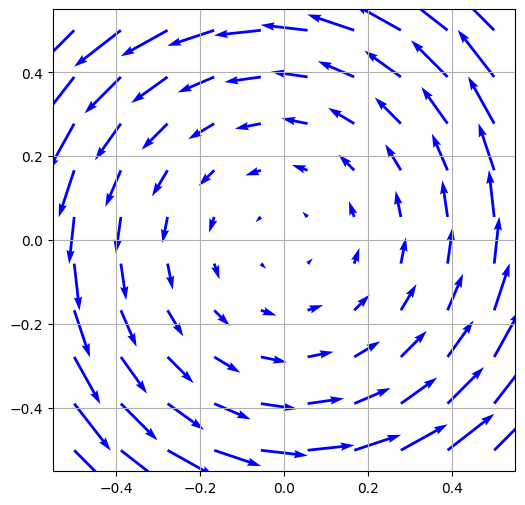

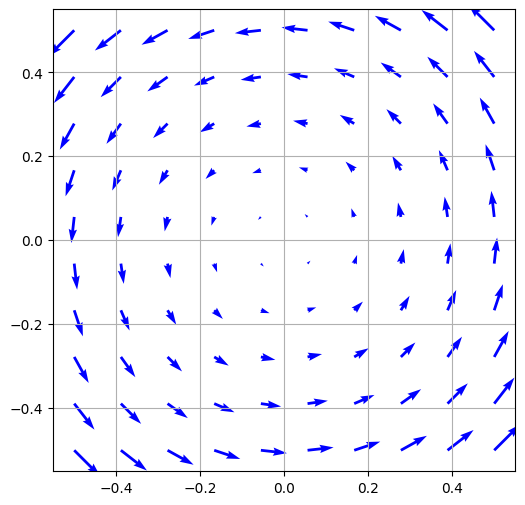

In [6]:
from src.plotting.differential.vector_field import plot_learned_generator

fig, axes = plt.subplots(1, 1, figsize=(15, 6), sharex=True, sharey=True)

plot_learned_generator(generator=diff_generator.g, ax=axes, quiver_scale=0.1)
fig, axes = plt.subplots(1, 1, figsize=(15, 6), sharex=True, sharey=True)

plot_learned_generator(generator=func_generator.g, ax=axes, quiver_scale=2)

## How do the generators move along the parameter space?

- Perform PCA on both generator optimization trajectories to get main directions of change, project to two dimensions for plotting.

In [7]:
import numpy as np

def compute_condition_numbers(hessians: list) -> np.array:
    """Computes the condition number of a list of tensors."""
    condition_numbers = []
    idxs_no_hessian = []
    for idx_hessian, hessian_diff in enumerate(hessians):
        try:
            condition_numbers.append(torch.linalg.cond(hessian_diff))
        except:
            condition_numbers.append(0)
            idxs_no_hessian.append(idx_hessian)
    cond_nums_np = np.array(condition_numbers)
    return cond_nums_np, idxs_no_hessian

gs_diff = diff_generator.gs
gs_func = func_generator.gs

gs_diff_tensor = torch.cat(gs_diff)
gs_func_tensor = torch.cat(gs_func)
gs_diff_tensor = gs_diff_tensor.reshape(gs_diff_tensor.shape[0], -1)
gs_func_tensor = gs_func_tensor.reshape(gs_func_tensor.shape[0], -1)

# Project tensors to two-dimensional space via PCA
VISUALIZATION_DIM=2
gs_tensor = torch.vstack([gs_diff_tensor, gs_func_tensor])
_, _, pca_vectors = torch.pca_lowrank(gs_tensor, q=VISUALIZATION_DIM)
gs_diff_proj = torch.matmul(gs_diff_tensor, pca_vectors)
gs_func_proj = torch.matmul(gs_func_tensor, pca_vectors)

## Compute Hessian Loss Landscape for both functional and differential

### Step 1: Parameterize set of all generators as 2x2 matrix with entries a,b,c,d

In [8]:
MIN_MESH=-1
MAX_MESH=1
MESH_RESOLUTION = 10
a_range = torch.linspace(MIN_MESH, MAX_MESH, MESH_RESOLUTION)
b_range = torch.linspace(MIN_MESH, MAX_MESH, MESH_RESOLUTION)
c_range = torch.linspace(MIN_MESH, MAX_MESH, MESH_RESOLUTION)
d_range = torch.linspace(MIN_MESH, MAX_MESH, MESH_RESOLUTION)

a,b,c,d = torch.meshgrid(a_range, b_range, c_range, d_range, indexing="xy")
a_flat, b_flat, c_flat, d_flat = a.reshape(-1), b.reshape(-1), c.reshape(-1), d.reshape(-1)

# linspace_generators is a uniform covering of the space of generators within the mesh boundaries of shape #(MESH_RESOLUTION**d, d)
# where d is the number of arguments in the generator (4 in our case)
mesh_generators = torch.stack([a_flat, b_flat, c_flat, d_flat], dim=1) 

## Step 2: Compute Hessian of loss function over mesh
### Step 2a: Use differential loss function

In [9]:
mesh_loss_diff = []
mesh_loss_func = []
mesh_hessians_diff = []
mesh_hessians_func = []
batch_size_mesh = 250

diff_generator = DiffGenerator(
    g_0=None,
    p=p,
    bases=kernel_bases,
    batch_size=batch_size_mesh,
    n_steps = 1,
    optimizer=None)

# Always evaluate hessian on same points on manifold for comparability
p_mesh, bases_mesh = diff_generator._sample_data(n_samples = batch_size_mesh)


for mesh_generator in tqdm(mesh_generators, desc="Computing Hessians of Differential Loss Surface"):
    mesh_generator = mesh_generator.view(2, 2)
    mesh_loss_diff.append(diff_generator._compute_loss(generator=mesh_generator, p_batch=p_mesh, bases_batch=bases_mesh).detach().numpy())
    mesh_hessians_diff.append(diff_generator._compute_hessian(generator=mesh_generator, p_batch=p_mesh, bases_batch=bases_mesh))

/Users/paulnitschke/Desktop/projects/geo_meta_rl/src/learning/symmetry_discovery/differential/diff_generator.py:53: UserWarning: Differential Generator is not Normalized During Training
  warnings.warn("Differential Generator is not Normalized During Training")
Computing Hessians of Differential Loss Surface: 100%|██████████| 10000/10000 [00:41<00:00, 240.51it/s]


### Step 2b: Use functional loss function

In [10]:
func_generator = FuncGenerator(
    g_0=mesh_generators[0,:].view(1, 2,2),
    p=p,
    f=f,
    batch_size=batch_size_mesh,
    optimizer=None,
    n_steps = 1,)

p_mesh_func, g_mesh_func = func_generator._sample_data(n_samples = batch_size_mesh)

for mesh_generator in tqdm(mesh_generators, desc="Computing Hessians of Functional Loss Surface"):
    mesh_generator = mesh_generator.view(2, 2)
    mesh_loss_func.append(func_generator._compute_loss(generator=mesh_generator, p_batch=p_mesh_func, group_coeffs_batch=g_mesh_func).detach().numpy())
    mesh_hessians_func.append(func_generator._compute_hessian(generator=mesh_generator, p_batch=p_mesh_func, group_coeffs_batch=g_mesh_func))

/Users/paulnitschke/Desktop/projects/geo_meta_rl/src/learning/symmetry_discovery/functional/func_generator.py:50: UserWarning: Sampled group actions are in 2pi range.
  warnings.warn("Sampled group actions are in 2pi range.")
Computing Hessians of Functional Loss Surface:  75%|███████▍  | 7487/10000 [02:23<00:47, 52.96it/s]

## Step 3: Compute condition numbers over hessian mesh
- Interpolate to 2-D surface for plotting

In [91]:
from scipy.interpolate import griddata

mesh_cond_nums_diff, _ = compute_condition_numbers(mesh_hessians_diff)
mesh_cond_nums_func, _ = compute_condition_numbers(mesh_hessians_func)

# Project mesh to two-dimensions via PCA
mesh_generators_proj = torch.matmul(mesh_generators, pca_vectors)

mesh_generators_proj_np = mesh_generators_proj.detach().numpy()

def interpolate(x, y, z):
    # Create regular grid
    xi = np.linspace(x.min(), x.max(), 500)
    yi = np.linspace(y.min(), y.max(), 500)
    xi, yi = np.meshgrid(xi, yi)

    # Interpolate
    zi = griddata((x, y), z, (xi, yi), method='cubic')
    return xi, yi, zi

x = mesh_generators_proj_np[:, 0]
y = mesh_generators_proj_np[:, 1]

xi, yi, zi_loss_diff = interpolate(x,y,np.array(mesh_loss_diff))
xi, yi, zi_loss_func = interpolate(x,y,np.array(mesh_loss_func))

xi, yi, zi_hess_diff = interpolate(x,y,mesh_cond_nums_diff)
xi, yi, zi_hess_func = interpolate(x,y,mesh_cond_nums_func)

## Step 4: Plot both optimization trajectories and condition numbers over mesh

/var/folders/cm/rfx_nb1x16zcxk4frrwkp_1r0000gn/T/ipykernel_76767/3913142720.py:12: UserWarning: Log scale: values of z <= 0 have been masked
  cf1 = axs[0].contourf(xi, yi, zi_hess_diff, levels=200, cmap='coolwarm', norm=mcolors.LogNorm())
/var/folders/cm/rfx_nb1x16zcxk4frrwkp_1r0000gn/T/ipykernel_76767/3913142720.py:13: UserWarning: Log scale: values of z <= 0 have been masked
  cf2 = axs[1].contourf(xi, yi, zi_hess_func, levels=200, cmap='coolwarm', norm=mcolors.LogNorm())
/var/folders/cm/rfx_nb1x16zcxk4frrwkp_1r0000gn/T/ipykernel_76767/3913142720.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.95, 1])


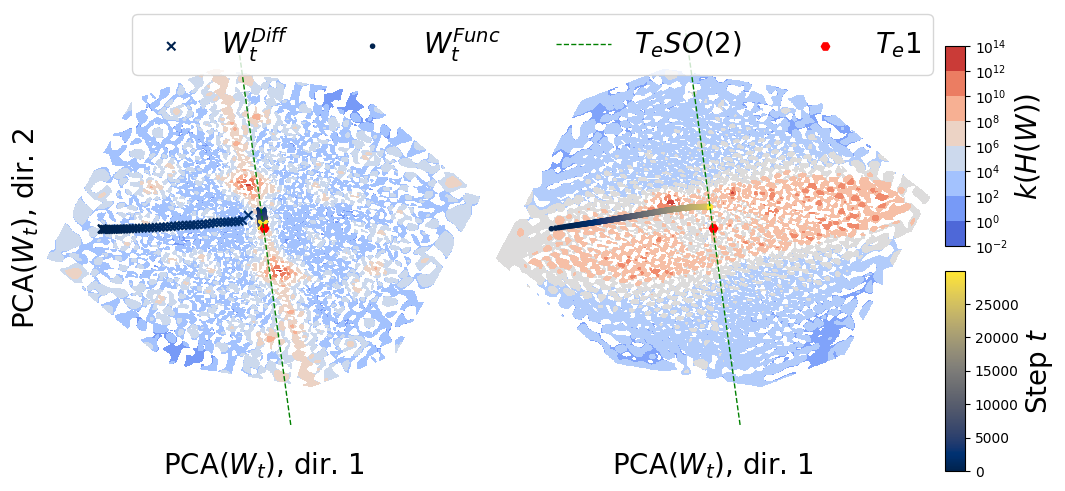

In [126]:
import matplotlib.colors as mcolors

# W Optimization trajectory of both approaches. Subsample every n-th point for easier plotting
N_SUBSAMPLING = 50
optimization_steps = np.arange(gs_diff_proj.shape[0])[::N_SUBSAMPLING]
gs_diff_proj_sub = gs_diff_proj.detach().numpy()[::N_SUBSAMPLING]
gs_func_proj_sub = gs_func_proj.detach().numpy()[::N_SUBSAMPLING]

# Plot Optima of both loss functions
global_optimum_1 = torch.tensor([[0, -1.5, 1.5, 0]], dtype=DTYPE)
global_optimum_2 = torch.tensor([[0, 1.5, -1.5, 0]], dtype=DTYPE)
identity_subgroup = torch.tensor([[0, 0, 0, 0]], dtype=DTYPE)
global_optima = torch.vstack([global_optimum_1, global_optimum_2])
global_optima_proj = torch.matmul(global_optima, pca_vectors).detach().numpy()
origin_proj = torch.matmul(identity_subgroup, pca_vectors).detach().numpy()

fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
cf1 = axs[0].contourf(xi, yi, zi_hess_diff, levels=200, cmap='coolwarm', norm=mcolors.LogNorm())
cf2 = axs[1].contourf(xi, yi, zi_hess_func, levels=200, cmap='coolwarm', norm=mcolors.LogNorm())
sct_1 = axs[0].scatter(gs_diff_proj_sub[:, 0], gs_diff_proj_sub[:, 1], c=optimization_steps, cmap='cividis', marker="x", label="$W_t^{Diff}$")
axs[1].scatter(gs_func_proj_sub[:, 0], gs_func_proj_sub[:, 1], c=optimization_steps, cmap='cividis', marker=".", label="$W_t^{Func}$")
# Make room at the bottom
fig.subplots_adjust(right=0.75)

# Manually add colorbar below both plots
cbar_ax_cond = fig.add_axes([0.95, 0.5, 0.02, 0.4])  # [left, bottom, width, height]
fig.colorbar(cf1, cax=cbar_ax_cond, orientation='vertical', label='$k(H(W))$')
cbar_ax_cond.yaxis.label.set_size(LABEL_FONT_SIZE)
cbar_ax_time = fig.add_axes([0.95, 0.05, 0.02, 0.4])  # [left, bottom, width, height]
fig.colorbar(sct_1, cax=cbar_ax_time, orientation='vertical', label='Step $t$')
cbar_ax_time.yaxis.label.set_size(LABEL_FONT_SIZE)

#Plot optima
axs[0].plot(global_optima_proj[:,0], global_optima_proj[:,1], linestyle='--', linewidth=1, color='green')
axs[0].scatter(origin_proj[:,0], origin_proj[:,1], c="red", marker="H")
axs[1].plot(global_optima_proj[:,0], global_optima_proj[:,1], linestyle='--', linewidth=1, color='green', label="$T_eSO(2)$")
axs[1].scatter(origin_proj[:,0], origin_proj[:,1], label="$T_e1$", c="red", marker="H")

axs[0].set_xlabel('PCA$(W_t)$, dir. 1', fontsize=LABEL_FONT_SIZE)
axs[1].set_xlabel('PCA$(W_t)$, dir. 1', fontsize=LABEL_FONT_SIZE)
axs[0].set_ylabel('PCA$(W_t)$, dir. 2', fontsize=LABEL_FONT_SIZE)
fig.legend(fontsize=LABEL_FONT_SIZE, ncols=4, loc="upper center")
for ax in axs:
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    for spine in ax.spines.values():
        spine.set_visible(False)

plt.tight_layout(rect=[0, 0, 0.95, 1])
plt.show()

## Plot raw loss functions

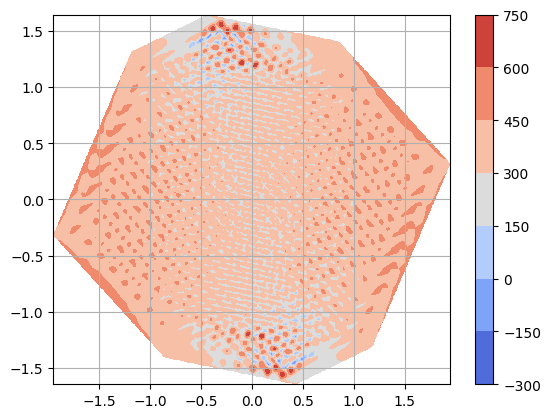

In [130]:
plt.contourf(xi, yi, zi_loss_diff, cmap="coolwarm")
plt.colorbar()
plt.grid()

/var/folders/cm/rfx_nb1x16zcxk4frrwkp_1r0000gn/T/ipykernel_76767/4132845646.py:1: UserWarning: Log scale: values of z <= 0 have been masked
  plt.contourf(xi, yi, zi_loss_func, norm=mcolors.LogNorm(), cmap="coolwarm")


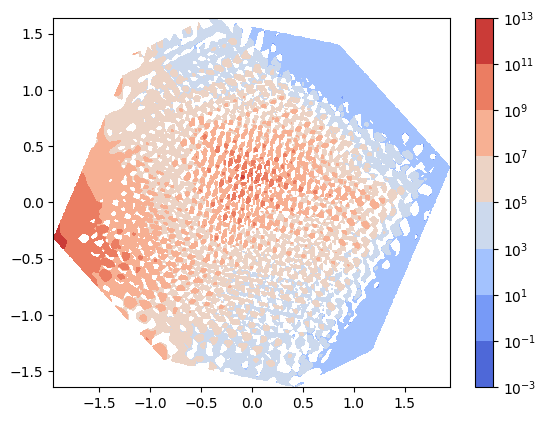

In [131]:
plt.contourf(xi, yi, zi_loss_func, norm=mcolors.LogNorm(), cmap="coolwarm")
plt.colorbar()